# outline of 'Revealing non-canonical RNA interactions in DMS chemical mapping'

## Extra resources
current draft: https://uofnelincoln-my.sharepoint.com/:w:/r/personal/jyesselman2_unl_edu/_layouts/15/Doc.aspx?sourcedoc=%7B2AAE1849-B2EB-44FC-8A5F-1ED79D0654BC%7D&file=draft_9.docx&action=default&mobileredirect=true

## Notebook setup
NOTE: all data is assumed to be in '../data' and this notebook will not work if the data is in another location!

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    publication_style_ax,
    plot_motif_boxplot_stripplot,
    plot_scatter_w_best_fit_line,
)
from dms_3d_features.pdb_features import compute_solvent_accessibility_all

## extra functions

In [50]:
def r2(x, y):
    return pearsonr(x, y)[0] ** 2

In [51]:
def format_small_plot(ax):
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)
    plt.subplots_adjust(left=0.3, bottom=0.21, top=0.98)

In [52]:
def generate_replicate_df(df_construct: pd.DataFrame, df_construct_2) -> pd.DataFrame:
    """
    Generates a replicate DataFrame by merging two input DataFrames based on the 'name' column.

    Args:
        df_construct (pandas.DataFrame): The first DataFrame containing the 'name' and 'data' columns.
        df_construct_2 (pandas.DataFrame): The second DataFrame containing the 'name' and 'data' columns.

    Returns:
        pandas.DataFrame: A new DataFrame with columns 'data_1' and 'data_2', where
            each row contains a pair of corresponding data values from the input DataFrames.

    Raises:
        None
    """
    df_2_sub = df_construct_2[["name", "data"]].copy()
    df_2_sub.rename(columns={"data": "data_2"}, inplace=True)
    df_merge = df_construct.merge(df_2_sub, on="name").copy()
    data = []
    for i, row in df_merge.iterrows():
        for d1, d2 in zip(row["data"], row["data_2"]):
            data.append({"data_1": d1, "data_2": d2})
    df_data = pd.DataFrame(data)
    return df_data

## load data

In [53]:
DATA_PATH = "../data"

load all the data from the data folder<br>
`df_construct` is all the data of constructs before any processing<br>
`df_construct_2` is the replicate date to compare reproduceability<br>
`df_motif` is processing all the constructs so that motifs are grouped together<br>
`df` is processed data where all resiudes have their own row<br>

In [54]:
df_construct = pd.read_json(
    f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1_combined.json"
)
df_construct_2 = pd.read_json(
    f"{DATA_PATH}/raw-jsons/constructs/pdb_library_2_combined.json"
)
df_motif = pd.read_json(
    f"{DATA_PATH}/raw-jsons/motifs/pdb_library_1_motifs_standard.json"
)
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")

In [55]:
df["ln_r_data"] = np.log(df["r_data"])
df["ln_r_data"].replace(-np.inf, -9.8, inplace=True)

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [56]:
# TODO give explanation of each feature
df.iloc[0]

both_purine                     False
both_pyrimidine                 False
constructs              construct1249
has_pdbs                        False
likely_pair                        AU
m_flank_bp_5p                      AU
m_flank_bp_3p                      AU
m_orientation             non-flipped
m_pos                               4
m_second_flank_bp_5p               CG
m_second_flank_bp_3p               UA
m_sequence                    AAA&UAU
m_structure                   (.(&).)
m_token                           1x1
n_pdbs                              0
pair_type                         NaN
p5_res                           None
p5_type                    PYRIMIDINE
p3_res                              A
p3_type                        PURINE
r_data                        0.00147
r_nuc                               A
r_loc_pos                           0
r_pos                              33
r_type                             WC
pdb_path                           []
pdb_r_pos   

# Results

## Designing a massive RNA library to investigate the relationship between DMS reactivity and non-canonical interactions.  

## DMS reactivity is highly reproducible and spans five orders of magnitude. 

### Outline 

1. DMS spans five orders of magnitude (Figure 1C)<br><br>
min val:  6.0e-05<br>
max val:  0.50<br>
count:  237528<br>

2. DMS reactivity is highly reproducible (Figure 1D)<br><br>
r2 = 0.99<br>

3. DMS reactivity is highly local compare to full structures **TODO**<br><br>



### Analysis

#### find highest and lowest DMS values

In [57]:
lowest_non_zero_value = df[df["r_data"] != 0]["r_data"].min()
print("min val: ", lowest_non_zero_value)
print("max val: ", df["r_data"].max())
print("count: ", len(df))

min val:  6.000000000000001e-05
max val:  0.5006900000000001
count:  237528


#### corelation between replicates

In [74]:
df_data = generate_replicate_df(df_construct, df_construct_2)
print("r2: ", r2(df_data["data_1"], df_data["data_2"]))

r2:  0.9904858197439976


### Figure 1

#### Figure 1B: construct to highlight diversity of structures. Find one with the most different motifs

In [59]:
def figure_1b(df_construct, ax):
    row = df_construct.iloc[7000].to_dict()
    row["sequence"] = row["sequence"][1:]
    row["structure"] = row["structure"][1:]
    row["data"] = row["data"][1:]
    ax = plot_pop_avg_from_row(row, ax=ax)
    ax.set_xlabel("Nucleotide", labelpad=2)
    ax.set_ylabel("Mutation Fraction", labelpad=2)
    ax.set_yticks([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06])
    ax.set_xlim(-1, 112)
    ax.tick_params(axis="x", which="both", bottom=False, top=False, size=-1)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=4)

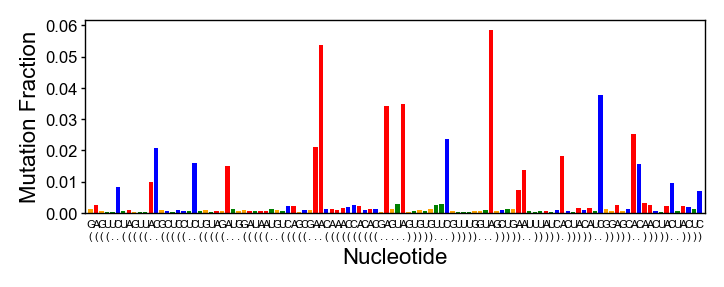

In [60]:
fig, ax = plt.subplots(figsize=(4.00, 1.25), dpi=200)
figure_1b(df_construct, ax)

#### Figure 1C: mutation fractions of DMS reactivity are highly reproducible

In [61]:
def figure_1c(df_construct, df_construct_2, ax):
    # prepare data for plot
    df_data = generate_replicate_df(df_construct, df_construct_2)
    # generate plot
    plot_scatter_w_best_fit_line(df_data["data_1"], df_data["data_2"], ax=ax)
    ax.set_xlabel("Mut. Frac. Run 1", labelpad=2)
    ax.set_ylabel("Mut. Frac. Run 2", labelpad=2)
    ax.set_xticks([0.00, 0.20, 0.40])
    ax.set_yticks([0.00, 0.20, 0.40])
    format_small_plot(ax)

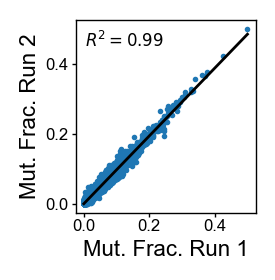

In [62]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1c(df_construct, df_construct_2, ax)

#### Figure 1D: histogram of DMS reactivity in Ln space visualize the distribution over the five orders of magnitude

In [63]:
def figure_1d(df, ax):
    ax.hist(df["ln_r_data"], bins=25)
    ax.set_yscale("log")
    ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)
    ax.set_yticks([10, 100, 1000, 10000])
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    format_small_plot(ax)

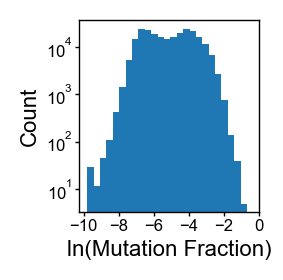

In [64]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1d(df, ax)

#### Figure 1E: how often does each motif occur

In [65]:
def figure_1e(df_motif, ax):
    data = []
    for i, group in df_motif.groupby("m_sequence"):
        data.append([i, len(group)])
    df_counts = pd.DataFrame(data, columns=["m_sequence", "count"])
    ax.set_xlabel("Motif Count", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)
    plt.hist(df_counts["count"], bins=100)
    format_small_plot(ax)

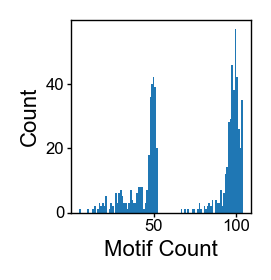

In [66]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1e(df_motif, ax)

#### Figure 1F: example motif

In [67]:
def figure_1f(df, ax):
    df_motif_example = df[df["m_sequence"] == "GGGAAAG&UAACAC"]
    plot_motif_boxplot_stripplot(df_motif_example, ax=ax)
    ax.set_xlabel("Residues", labelpad=2)
    ax.set_ylabel("Mutation Fraction", labelpad=2)
    format_small_plot(ax)

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:378: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


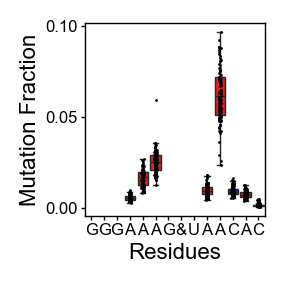

In [68]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1f(df, ax)

#### Figure 1G: reactivity avg vs std

In [69]:
def figure_1g(df, ax):
    data = []
    for i, group in df.groupby(["r_loc_pos", "m_sequence"]):
        data.append([group["r_data"].mean(), group["r_data"].std()])
    df_data = pd.DataFrame(data, columns=["mean", "std"])
    plot_scatter_w_best_fit_line(np.log(df_data["mean"]), np.log(df_data["std"]), ax=ax)
    ax.set_xlabel("ln(Avg. Mut. Frac.)", labelpad=2)
    ax.set_ylabel("ln(Std. Mut. Frac.)", labelpad=2)
    ax.set_yticks([-2, -4, -6, -8])
    ax.set_xticks([-8, -6, -4, -2])
    format_small_plot(ax)

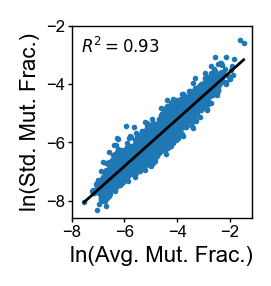

In [70]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1g(df, ax)

#### Figure 1H: coefficient of variation

In [71]:
def figure_1h(df, ax):
    data = []
    for i, group in df.groupby(["r_loc_pos", "m_sequence"]):
        data.append(group["r_data"].std() / group["r_data"].mean())
    plt.hist(data, bins=50)
    format_small_plot(ax)
    ax.set_xlabel("Coefficient of Variation", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)

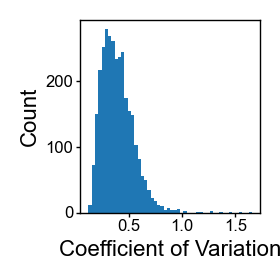

In [72]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1h(df, ax)

### Supplemental Figures / Information

#### How many aligns were there?

In [73]:
df["num_aligned"].describe()

KeyError: 'num_aligned'

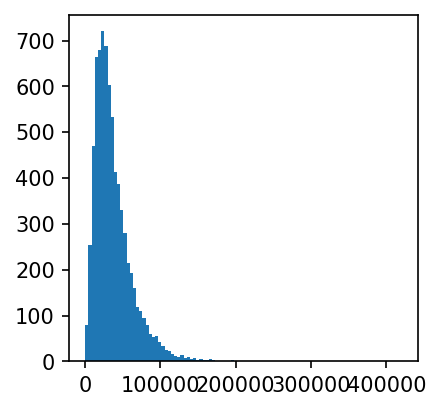

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.hist(df["num_aligned"], bins=100)

##### What is the average Coefficient Variation?

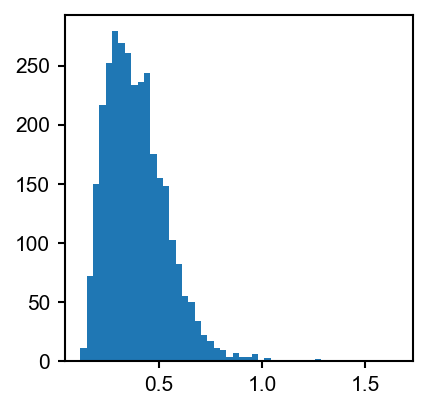

In [ ]:
data = []
for i, group in df_residue.groupby(["r_loc_pos", "m_sequence"]):
    data.append(group["r_data"].std() / group["r_data"].mean())

fig, ax = plt.subplots(figsize=(3, 3))
plt.hist(data, bins=50)
publication_style_ax(ax)

In [ ]:
np.mean(data)

0.3942839835926987

##### individual measurements to std 

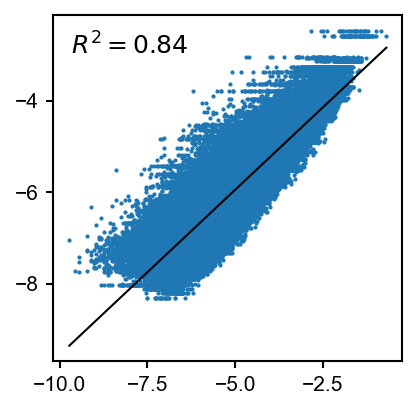

In [ ]:
data = []
for i, group in df_residue.groupby(["r_loc_pos", "m_sequence"]):
    std = group["r_data"].std()
    if std == 0:
        continue
    for _, row in group.iterrows():
        if row["r_data"] == 0:
            continue
        data.append([row["r_data"], std])
df_data = pd.DataFrame(data, columns=["r_data", "std"])
df_data["ln_r_data"] = np.log(df_data["r_data"])

fig, ax = plt.subplots(figsize=(3, 3))
plot_scatter_w_best_fit_line(np.log(df_data["r_data"]), np.log(df_data["std"]), ax=ax)
publication_style_ax(ax)

## DMS reactivity values are continuous, and a significant overlap exists between Watson-Crick and non-canonical interactions.